In [24]:
from __future__ import annotations
import jijmodeling as jm
import jijmodeling_transpiler.core as jtc
import jijmodeling_transpiler_quantum.core as jtqc
import jijmodeling_transpiler as jmt
import jijmodeling_transpiler_quantum.quri_parts as jq_qu

from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
)
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.circuit import (
    LinearMappedUnboundParametricQuantumCircuit,
    Parameter,
)
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.operator import Operator, pauli_label

from scipy.optimize import minimize, OptimizeResult

import matplotlib.pyplot as plt

import openjij as oj

import numpy as np
import matplotlib.pyplot as plt

# from util import *

from itertools import product, islice
from dwave_qbsolv import QBSolv
import math
import copy

from dwave.samplers import SteepestDescentSampler, SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler, LeapHybridSampler



In [3]:
np.set_printoptions(precision=5)


loc_num = 16
log2loc_num = math.ceil(np.log2(loc_num))
required_qubo_size = int(loc_num*log2loc_num + loc_num*0.5*(log2loc_num)*(log2loc_num-1))
print("required_qubo_size = ", required_qubo_size)
binary_vectors = [list(i) for i in list(product([0, 1], repeat=log2loc_num))]
binary_vectors = np.array([np.array(i) for i in binary_vectors])
print("binary_vectors = \n", binary_vectors)
encoding_bias = [1] + [0 for i in range(2**log2loc_num-1)]
A_matrix = binary_vectors @ binary_vectors.T + encoding_bias
A_matrix_pinv = np.linalg.pinv(A_matrix)

# binary encoding overflow
for i in range(2**log2loc_num):
    for j in range(2**log2loc_num):
        if i >= loc_num and j >= loc_num:
            A_matrix_pinv[i][j] = 0 
            
# print( A_matrix @ A_matrix_pinv)

normalized_sum = 0
normalized_sum_loc = 0

for i in range(loc_num):
    normalized_sum += (((binary_vectors[i] @ binary_vectors.T + encoding_bias) @ A_matrix_pinv)**2 )[0]
    #print(normalized_sum)
for i in range(loc_num):#2**log2loc_num):
    normalized_sum_loc += (((binary_vectors[0] @ binary_vectors.T + encoding_bias) @ A_matrix_pinv)**2 )[i]
    print(normalized_sum_loc)
    
print(normalized_sum_loc)
print(normalized_sum)


# encoding transformation : 
for i in range(loc_num):
    print(
        ((binary_vectors[i] @ binary_vectors.T @ A_matrix_pinv + encoding_bias @ A_matrix_pinv) ) ** 2
    )

phi_data = binary_vectors.T @ A_matrix_pinv
psi_data =  encoding_bias @ A_matrix_pinv
print("phi_data = \n", phi_data)
print("psi_data = \n", psi_data)

required_qubo_size =  160
binary_vectors = 
 [[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]
0.09765625000000007
0.1328125000000001
0.16796875000000017
0.17187500000000017
0.20703125000000022
0.21093750000000022
0.21484375000000022
0.21875000000000022
0.2539062500000003
0.2578125000000003
0.2617187500000003
0.2656250000000003
0.2695312500000003
0.2734375000000003
0.2773437500000003
0.31250000000000033
0.31250000000000033
0.3125000000000002
[0.09766 0.03516 0.03516 0.00391 0.03516 0.00391 0.00391 0.00391 0.03516
 0.00391 0.00391 0.00391 0.00391 0.00391 0.00391 0.03516]
[0.03516 0.09766 0.00391 0.03516 0.00391 0.03516 0.00391 0.00391 0.00391
 0.03516 0.00391 0.00391 0.00391 0.00391 0.03516 0.00391]
[0.03516 0.00391 0.09766 0.03516 0.00391 0.00391 0.03516 0.00391 0.00391
 0.00391 0.03516 0.00391 0.00391 0.03516 0.00391 0.00391]
[0.00391 0.03516 0.03516 0.09766 0

In [4]:
from geopy.distance import geodesic


def geo_dis_cal(sol_res):
    total_distance = 0
    for i_ in range(len(sol_res)-1):
        # print("location ", sol_res[i_], sol_res[i_+1])
        total_distance += geodesic(
            (x_pos[sol_res[i_]], y_pos[sol_res[i_]]),
            (x_pos[sol_res[i_+1]], y_pos[sol_res[i_+1]])).kilometers
        
    return total_distance

def generate_random_instance(n,  X_range, Y_range):
    x_pos = [np.random.randint(0, X_range) for _ in range(n)]
    y_pos = [np.random.randint(0, Y_range) for _ in range(n)]
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2) #+ np.diag([10000 for i in range(n)])
    
    return x_pos, y_pos, distance

def generate_ulysses16_instance():
    x_pos = [38.24, 39.57, 40.56, 36.26, 33.48, 37.56, 38.42, 37.52, 41.23, 41.17, 36.08, 38.47, 38.15, 37.51, 35.49, 39.36]
    y_pos = [20.42, 26.15, 25.32, 23.12, 10.54, 12.19, 13.11, 20.44,  9.10, 13.05, -5.21, 15.13, 15.35, 15.17, 14.32, 19.56]
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    # distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2) #+ np.diag([10000 for i in range(n)])
    distances = np.zeros((16, 16))
    for i in range(16):
        for j in range(i+1, 16):
            distances[i][j] = geodesic(
            (x_pos[i], y_pos[i]),
            (x_pos[j], y_pos[j])).kilometers#np.sqrt((x_pos[i] - x_pos[j])**2 + (y_pos[i] - y_pos[j])**2)
            distances[j][i] = distances[i][j]
                
    return x_pos, y_pos, distances

In [5]:
x_pos, y_pos, distance = generate_ulysses16_instance()#generate_random_instance(loc_num, 100, 100)

distance_dict = {}
for ind_i, i in enumerate(distance):
    for ind_j, j in enumerate(i):
        if ind_j > ind_i:
            distance_dict[(ind_i, ind_j)] = distance[ind_i][ind_j]

print("x_pos: ", x_pos)
print("y_pos: ", y_pos)
print("distance: ", distance)

x_pos:  [38.24, 39.57, 40.56, 36.26, 33.48, 37.56, 38.42, 37.52, 41.23, 41.17, 36.08, 38.47, 38.15, 37.51, 35.49, 39.36]
y_pos:  [20.42, 26.15, 25.32, 23.12, 10.54, 12.19, 13.11, 20.44, 9.1, 13.05, -5.21, 15.13, 15.35, 15.17, 14.32, 19.56]
distance:  [[   0.       518.38895  494.33697  325.03682 1036.07347  727.52027
   639.31214   79.9352  1024.66814  710.51237 2281.82914  463.02521
   444.18563  468.88615  623.49168  145.04976]
 [ 518.38895    0.       130.75627  453.76831 1549.87774 1235.63124
  1135.86078  547.19536 1456.72853 1125.5744  2773.74353  961.51258
   949.95849  983.51928 1138.29752  567.46444]
 [ 494.33697  130.75627    0.       514.49322 1528.98121 1182.91875
  1075.94352  540.58937 1366.87291 1035.79562 2701.6809   905.89471
   899.42425  941.08293 1116.5579   509.76306]
 [ 325.03682  453.76831  514.49322    0.      1189.84779  984.0853
   918.30607  276.79026 1335.79364 1030.53131 2539.73912  748.7694
   720.68068  721.91727  798.98772  465.38759]
 [1036.07347 1549.8

#### Augmented Lagrangian Method  

ALM:  
https://aqc2021.org/poster2/a/A7.pdf?fbclid=IwAR3XR0aVMiBjNm7ciLXKpMSrOiMJXuhNmMRTG19Zm2_Y3A_aIY0NYXTT-sU

Mapping constraints to penalty:  
https://arxiv.org/ftp/arxiv/papers/1811/1811.11538.pdf

In [6]:
def tsp_problem_ALM()-> jm.Problem:
    
    # define variables
    d = jm.Placeholder('D', ndim=2)
    phi = jm.Placeholder('\\phi', ndim=2)
    psi = jm.Placeholder('\\psi', ndim=1)
    
    
    N = d.len_at(0, latex="N") 

    i = jm.Element("i", belong_to=(0, N)) # 
    m = jm.Element("m", belong_to=(0, N)) # 
    k = jm.Element('k', belong_to=(0, N-1)) #
    q = jm.Element('q', belong_to=(0, N-2)) #
    
    j = jm.Element("j", belong_to=(0, log2loc_num)) # 
    l = jm.Element("l", belong_to=(0, log2loc_num)) # 
    n = jm.Element("n", belong_to=(0, log2loc_num)) # 
    p = jm.Element("p", belong_to=(0, log2loc_num)) # 

    alpha = jm.Element('\\alpha', belong_to=(0, N))
    beta = jm.Element('\\beta', belong_to=(0, N))
    x = jm.BinaryVar("x", shape=(N, log2loc_num))
    y = jm.BinaryVar("y", shape=(N, log2loc_num, log2loc_num))
    
    
    # set problem
    problem = jm.Problem('TSP new formulation')
    problem += jm.sum(alpha, jm.sum((beta, alpha != beta), d[alpha, beta]*jm.sum(k, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[k,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[k,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2)*\
                                (2*jm.sum(j, jm.sum((l, j<l),y[k+1,j,l]*phi[j,beta]*phi[l,beta] ))
                                +jm.sum(j, x[k+1,j]*(phi[j,beta]**2+2*phi[j,beta]*psi[beta] )) + psi[beta]**2)
                            )))
                                                                                
    
    problem += jm.Constraint('non-repeat location penalty', jm.sum(i, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum == 1, forall=alpha  )
    problem += jm.CustomPenaltyTerm('non-repeat location penalty linear', -1*(jm.sum(i, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum - 1), forall=alpha  )
    
    
    problem += jm.Constraint('non-repeat step penalty', jm.sum(alpha, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum_loc == 1, forall=i  )
    problem += jm.CustomPenaltyTerm('non-repeat step penalty linear', -1*(jm.sum(alpha, 
                            (2*jm.sum(j, jm.sum((l, j<l),y[i,j,l]*phi[j,alpha]*phi[l,alpha] ))
                            +jm.sum(j, x[i,j]*(phi[j,alpha]**2+2*phi[j,alpha]*psi[alpha] )) + psi[alpha]**2))/normalized_sum_loc - 1), forall=i  )
    
                                    
    problem += jm.Constraint('mapping xx to y contraint 1', y[i,j,l] <= x[i,j], forall=[i,j,(l,j < l)])                    
    problem += jm.Constraint('mapping xx to y contraint 2', y[i,j,l] <= x[i,l], forall=[i,j,(l,j < l)])   
    problem += jm.Constraint('mapping xx to y contraint 3', x[i,l] + x[i,j] - y[i,j,l] <= 1, forall=[i,j,(l,j < l)])   

    # Update the penalty for xx to y mapping with mean violation 
    # A += mean(violation) 
    # So that if all mappings are satisfied, the penalty will not change (A = A+0)
    # https://www.documentation.jijzept.com/docs/jijzeptlab/tutorials/4TSP_with_parameter_search/

    # problem += jm.CustomPenaltyTerm('mapping xx to y contraint 1 linear', -1*(y[i,j,l] -  x[i,j]*y[i,j,l]), forall=[i,j,(l,j < l)]) 
    # problem += jm.CustomPenaltyTerm('mapping xx to y contraint 2 linear', -1*(y[i,j,l] - x[i,l]*y[i,j,l]), forall=[i,j,(l,j < l)])   
    # problem += jm.CustomPenaltyTerm('mapping xx to y contraint 3 linear', -1*(x[i,l]*x[i,j] - x[i,j]*y[i,j,l] - x[i,l]*y[i,j,l]), forall=[i,j,(l,j < l)])   
    
    
    problem
    return problem


def check_unique_elements(array):
    """ Check if all elements in the numpy array are unique (non-repeated) """
    unique_elements = np.unique(array)
    return unique_elements.size == array.size


def g_m_c(sample_):
    sum_loc_cons_linear = 0 
    # i = 0
    for i in range(loc_num):
        for alpha in range(loc_num):
            for j in range(log2loc_num):
                for l in range(log2loc_num):
                    if j < l:
                        sum_loc_cons_linear += 2*sample_[compiled_instance.var_map.var_map['y'][(i,j,l)]]*phi_data[j][alpha]*phi_data[l][alpha]
                sum_loc_cons_linear += sample_[compiled_instance.var_map.var_map['x'][(i,j)]]*(phi_data[j][alpha]**2 + 2*phi_data[j][alpha]*psi_data[alpha])
            sum_loc_cons_linear += psi_data[alpha]**2
        sum_loc_cons_linear /= normalized_sum_loc
        sum_loc_cons_linear -= 1
        
    return sum_loc_cons_linear


def dis_calculate(distance_dict, sequence):
    """
    Calculate the total distance give the distance dict and path (location sequence)
    """
    total_distance = 0

    for i in range(len(sequence) - 1):
        current_location = sequence[i]
        next_location = sequence[i + 1]
        edge = (current_location, next_location)

        # Ensure the edge exists in the distance dictionary
        if edge in distance_dict:
            total_distance += distance_dict[edge]
        else:
            total_distance += distance_dict[edge[::-1]]

    return total_distance

In [7]:
problem_alm = tsp_problem_ALM()
problem_alm 

In [82]:


y_zero_list = {}
for i in range(loc_num):
    for j in range(log2loc_num):
        for k in range(log2loc_num):
            if j < k:
                #print((i,j,k))
                continue
            else:
                y_zero_list[(i,j,k)] = 0
                
compiled_instance = jtc.compile_model(tsp_problem_ALM(), {
                "D": distance,
                "\\phi": phi_data,
                "\\psi": psi_data,
                },
                fixed_variables={ 'y':y_zero_list}                    
                )

# 'x':{(0, i):0 for i in range(log2loc_num)},
pubo_builder = jtc.pubo.transpile_to_pubo(compiled_instance, normalize=True)

mu1   = 1
p1    = 1 
p2    = 1
p3    = 1
lam_1 = 0 
rho   = 1.03

num_iteration = 100
min_distance_list = [] 
min_distance_list_all = [] 
min_distance_sol_list = [] 
min_energy_list = [] 
min_energy_list_all = [] 

search_quota = 0 

for iteration in range(num_iteration):
    
    qubo, constant = pubo_builder.get_qubo_dict(
                multipliers={                
                    "non-repeat location penalty":mu1,
                    "non-repeat step penalty":mu1,
                    "non-repeat location penalty linear": lam_1,
                    "non-repeat step penalty linear": lam_1,
                    "mapping xx to y contraint 1":p1,
                    "mapping xx to y contraint 2":p2,
                    "mapping xx to y contraint 3":p3,
                    })

    # [item for index, item in compiled_instance.var_map.var_map['x'].items()]
    #compiled_instance.var_map.var_map['y']
    # qubo

    # sampler = oj.SASampler()
    
    # qpu_advantage = DWaveSampler(solver={'topology__type': 'pegasus', 'chip_id':'Advantage_system4.1'})
    # long_time = qpu_advantage.properties["annealing_time_range"][1]*0.46
    # print(
    #     "Using : ",qpu_advantage.properties["chip_id"]   
    # )
    # sampler = EmbeddingComposite(qpu_advantage)
    
    
    sampler = LeapHybridSampler()
    result = sampler.sample_qubo(qubo,
                                    # num_reads = 800,
                                    # annealing_time=long_time,
                                    label='Dwave bie qubo')
    print(result.info)
    
    
    # sampler = SimulatedAnnealingSampler()
    # result = sampler.sample_qubo(qubo, num_reads=1000, num_sweeps=10000)
    energy_list = [] 
    energy_list_all = []
    solution_list = [] 
    sum_loc_cons = []
    
    
    
    for i in range(len(list(result.samples()))):
        config = []
        for index, item in list(result.samples())[i].items():
            if index in [item for index, item in compiled_instance.var_map.var_map['x'].items()]:
                #print(index,": ", item)
                config.append(item)
            
        binary_array = (np.array(config)[:loc_num*log2loc_num].reshape(loc_num, log2loc_num))
        decimal_array_correct = np.sum(binary_array * [2**i for i in range(log2loc_num)][::-1], axis=1)
        
        
        
        sum_loc_cons.append(g_m_c(result.samples()[i]))

        if  check_unique_elements(decimal_array_correct) == True and np.sum(decimal_array_correct) == np.sum([list(range(int(loc_num)))]):
            
            # print("index = ", i)
            # print(decimal_array_correct, "True")
            # print(np.sum(decimal_array_correct))
            # print( np.sum([list(range(loc_num))]))
            # print("energy = ", result.data_vectors['energy'][i])
            energy_list.append(result.data_vectors['energy'][i])
            energy_list_all.append(result.data_vectors['energy'][i])
            solution_list.append(decimal_array_correct)
            
        else:
            # print(decimal_array_correct, "sum =", np.sum(decimal_array_correct))
            energy_list_all.append(result.data_vectors['energy'][i])
            continue
        


    if len(solution_list) == 0 and search_quota <= 0:
        print("===========")
        print("iter :",iteration,", no valid sample !")
        print("mu1: ", mu1, ", lam_1:", lam_1)
        print("p1:", p1, ", p2:", p2, ", p3: ", p3)
        print("search_quota: ", search_quota)
        
        # min_distance_list.append(None)
        # min_distance_sol_list.append(None)
        min_energy_list.append(None)
        min_energy_list_all.append(min(energy_list_all))
        
        
        sampleset = jtc.pubo.decode_from_openjij(
            result, pubo_builder, compiled_instance
        )


        sum_loc_cons = np.mean(np.array(sum_loc_cons))
        lam_1 = lam_1 - 2*mu1*sum_loc_cons
        mu1 = rho*mu1

        p1 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 1"])
        p2 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 2"])
        p3 += np.mean(sampleset.evaluation.constraint_violations["mapping xx to y contraint 3"])
        
    elif len(solution_list) == 0 and search_quota > 0:
        print("===========")
        print("iter :",iteration,", no valid sample !")
        print("mu1: ", mu1, ", lam_1:", lam_1)
        print("p1:", p1, ", p2:", p2, ", p3: ", p3)
        print("search_quota: ", search_quota)
        
        min_distance_list_all.append(None)
        # min_distance_sol_list.append(None)
        min_energy_list.append(None)
        min_energy_list_all.append(min(energy_list_all))
        search_quota -= 1
        
    elif len(solution_list) > 0:
        print("===========")
        print("iter :",iteration,", min distance in all sample: ", min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
        if len(solution_list) > 0:
            min_distance_list.append(min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
            min_distance_list_all.append(min([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))
            min_distance_sol_list.append(solution_list[np.argmin(np.array([dis_calculate(distance_dict, solution_list[i]) for i in range(len(solution_list))]))])
            min_energy_list.append(min(energy_list))
            min_energy_list_all.append(min(energy_list))
        else:
            min_energy_list.append(None)
            min_energy_list_all.append(min(energy_list_all))
        
        print("mu1: ", mu1, ", lam_1:", lam_1)
        print("p1:", p1, ", p2:", p2, ", p3: ", p3)
        print("search_quota: ", search_quota)
        
        search_quota += 5

    # compiled_instance.var_map.var_map['x']
    # compiled_instance.var_map.var_map['y']
    # result.samples()[0]
    # result.samples()[0][compiled_instance.var_map.var_map['y'][(0,0,2)]]


### Try default penalty as in 
### https://www.frontiersin.org/articles/10.3389/fict.2019.00013/full
### Not working, as we already use normalization of the coefficient 


{'qpu_access_time': 35933, 'charge_time': 2991762, 'run_time': 2991762, 'problem_id': '659ecb46-a950-4381-ab3a-f13c094fd52b', 'problem_label': 'Dwave bie qubo'}
iter : 0 , no valid sample !
mu1:  1 , lam_1: 0
p1: 1 , p2: 1 , p3:  1
search_quota:  0
{'qpu_access_time': 35931, 'charge_time': 2998151, 'run_time': 2998151, 'problem_id': 'aa0090ce-35c6-461d-ac95-6e2dd2a6b6a0', 'problem_label': 'Dwave bie qubo'}
iter : 1 , no valid sample !
mu1:  1.05 , lam_1: 1.3541161569818883e-07
p1: 1.0 , p2: 1.0 , p3:  1.0
search_quota:  0
{'qpu_access_time': 71151, 'charge_time': 2988974, 'run_time': 2988974, 'problem_id': 'a87410b3-751e-40d9-9723-363b7bddef16', 'problem_label': 'Dwave bie qubo'}
iter : 2 , no valid sample !
mu1:  1.1025 , lam_1: 2.1851823008844918e-07
p1: 1.0 , p2: 2.0 , p3:  1.0
search_quota:  0
{'qpu_access_time': 79718, 'charge_time': 2991468, 'run_time': 2991468, 'problem_id': '2c107566-12cc-4e73-a752-2a5ce3291825', 'problem_label': 'Dwave bie qubo'}
iter : 3 , no valid sample !
m

In [83]:
# min_distance_sol_list = min_distance_sol_list[1:]
sol_res = min_distance_sol_list[np.argmin([i for i in min_distance_list if i != None ])]
sol_res

array([ 9, 10,  4, 11, 12, 13,  5,  0,  7, 15,  8, 14,  1,  3,  2,  6])

In [84]:
min_distance_sol_list

[array([ 8,  9, 15, 13,  5,  6,  1, 12,  0,  4, 11, 14,  3,  2, 10,  7]),
 array([10,  4, 13, 12,  8, 11, 14,  3,  5,  0,  2,  6,  1,  7, 15,  9]),
 array([ 8, 13, 15,  5,  0, 10, 14,  1,  2, 12, 11,  9,  7,  3,  6,  4]),
 array([11,  1,  3, 13,  7,  6,  0,  9, 15,  4,  8, 10, 12, 14,  2,  5]),
 array([ 9, 10,  4, 11, 12, 13,  5,  0,  7, 15,  8, 14,  1,  3,  2,  6])]

In [85]:
min_distance_list

[12641.986856829524,
 10299.719716450578,
 11649.849731524422,
 12916.00103366502,
 10123.897931094125]

In [87]:
min_distance_sol_list

[array([ 8,  9, 15, 13,  5,  6,  1, 12,  0,  4, 11, 14,  3,  2, 10,  7]),
 array([10,  4, 13, 12,  8, 11, 14,  3,  5,  0,  2,  6,  1,  7, 15,  9]),
 array([ 8, 13, 15,  5,  0, 10, 14,  1,  2, 12, 11,  9,  7,  3,  6,  4]),
 array([11,  1,  3, 13,  7,  6,  0,  9, 15,  4,  8, 10, 12, 14,  2,  5]),
 array([ 9, 10,  4, 11, 12, 13,  5,  0,  7, 15,  8, 14,  1,  3,  2,  6])]

In [88]:
np.argsort(min_distance_list)

array([4, 1, 2, 0, 3])

In [89]:
min_energy_list

[None,
 None,
 None,
 None,
 -763.1402252557261,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 -2025.131290606502,
 None,
 None,
 None,
 -2025.1033137664824,
 None,
 -2025.119845856314,
 None,
 None,
 None,
 -2025.1195193449735,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [90]:
min_energy_list_all

[-627.2168269030077,
 -658.6033411466158,
 -693.7541976849736,
 -728.2787577191926,
 -763.1402252557261,
 -764.6561802918282,
 -763.7559100976287,
 -764.8599383700472,
 -763.3503850856105,
 -764.8710611147176,
 -762.6588664239873,
 -803.1583214387257,
 -843.3682365037591,
 -884.933125475725,
 -929.1199309454418,
 -975.8159658000083,
 -1024.3307038348248,
 -1074.207025516067,
 -1127.265534064974,
 -1186.1214759845475,
 -1245.9794538421254,
 -1306.6935008163714,
 -1368.7314355793255,
 -1440.2468309690385,
 -1514.28543344277,
 -1582.659963659777,
 -1668.5041687215232,
 -1753.3423361833663,
 -1840.1252635067276,
 -1930.1694126754028,
 -2025.131290606502,
 -2027.2207236527538,
 -2023.7453282645083,
 -2023.8937984634092,
 -2025.1033137664824,
 -2023.318706750409,
 -2025.119845856314,
 -2024.3079856683987,
 -2024.0107513800901,
 -2023.5273994748077,
 -2025.1195193449735,
 -2027.5631364601704,
 -2028.5204824906168,
 -2023.3961380387927,
 -2023.1861434768298,
 -2027.7606601313562,
 -2028.242649

In [91]:
min_distance_list

[12641.986856829524,
 10299.719716450578,
 11649.849731524422,
 12916.00103366502,
 10123.897931094125]

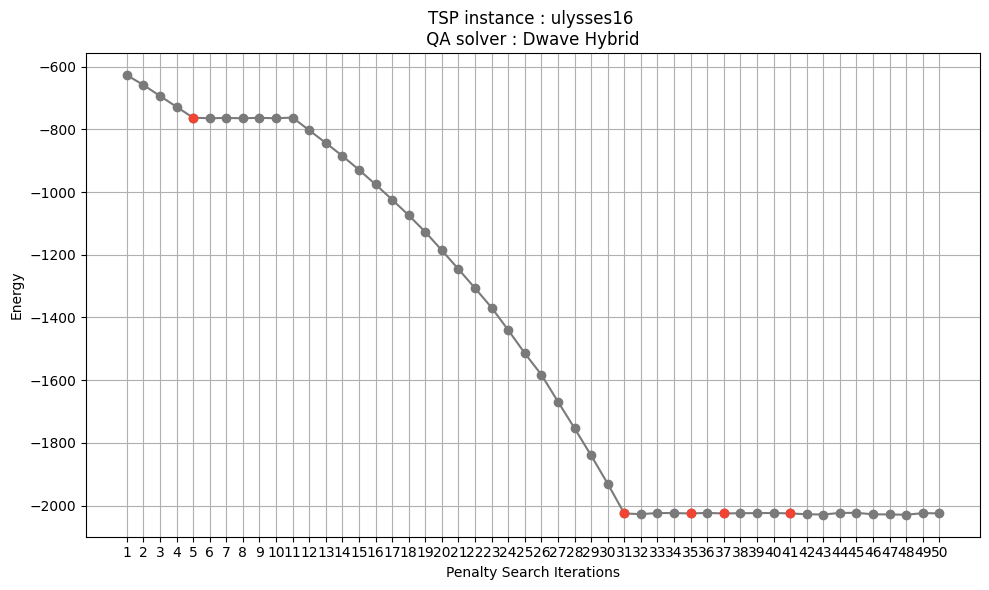

In [94]:
# min_distance_list 
# min_energy_list 

iterations = list(range(1, 51))

# Plotting the data with the legend
plt.figure(figsize=(10, 6))
# plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color='b') #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_energy_list_all, marker='o', linestyle='-', color=plt.cm.Greys(0.6)) #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color=plt.cm.Reds(0.6)) #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")

# plt.scatter(satisfied_iterations, satisfied_energies, color='r', s=100, zorder=5,marker = "x", label="Constraints Satisfied")

# plt.axhline(y=185, color='red', linestyle='--', label="Optimal Energy = 185")
plt.title('TSP instance : ulysses16 \n QA solver : Dwave Hybrid ')
plt.xlabel('Penalty Search Iterations')
plt.ylabel('Energy')
plt.grid(True)
plt.xticks(iterations)
# plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [97]:
min_distance_list

[12641.986856829524,
 10299.719716450578,
 11649.849731524422,
 12916.00103366502,
 10123.897931094125]

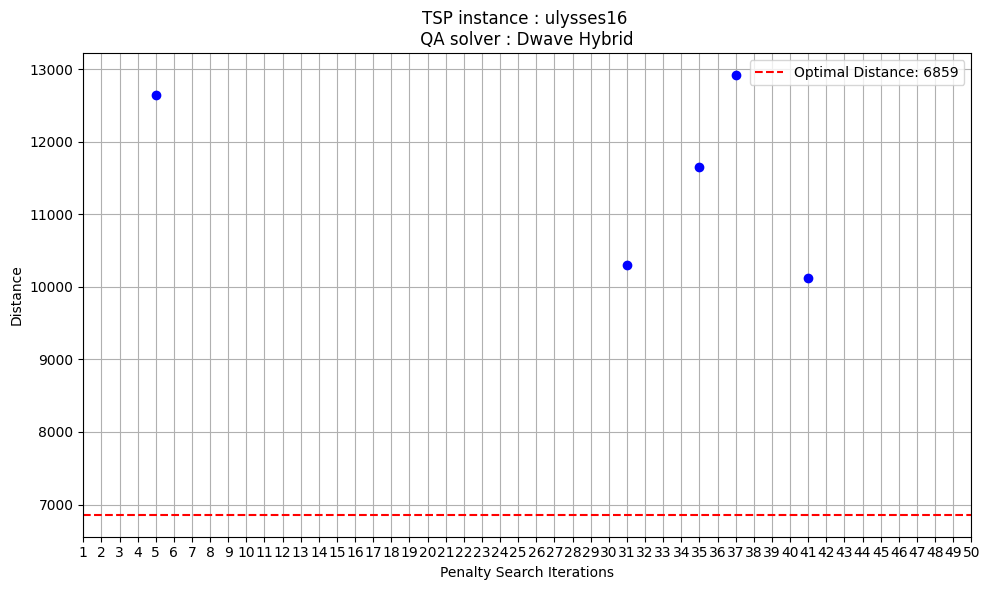

In [103]:
# min_distance_list 
# min_energy_list 

iterations = list(range(1, 51))

# Plotting the data with the legend
plt.figure(figsize=(10, 6))
# plt.plot(iterations, min_energy_list, marker='o', linestyle='-', color='b') #, label=f"µ = 2\nρ = 1.1")
plt.plot(iterations, min_distance_list_all, marker='o', linestyle='-', color='b') #, label = "Distance") #, label=f"µ = 2\nρ = 1.1")

# plt.scatter(satisfied_iterations, satisfied_energies, color='r', s=100, zorder=5,marker = "x", label="Constraints Satisfied")
plt.axhline(y=6859, color='red', linestyle='--', label="Optimal Distance: 6859")

# plt.axhline(y=185, color='red', linestyle='--', label="Optimal Energy = 185")
plt.title('TSP instance : ulysses16 \n QA solver : Dwave Hybrid ')
plt.xlabel('Penalty Search Iterations')
plt.ylabel('Distance')
plt.grid(True)
plt.xticks(iterations)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()